# 머신러닝 프로젝트
--------------

## Step 1. 문제를 정확하게 정의
## Step 2. 데이터 구하기
## Step 3. 데이터 탐색 및 시각화
## Step 4. 데이터 가공
## Step 5. 모델 선택 및 모델 훈련
## Step 6. 모델의 하이퍼파라미터 튜닝 및 성능 고도화
## Step 7. 솔루션 제시
## Step 8. 모델 배포 및 서비스 적용
-----

## 1. 문제를 정확하게 정의
- 해결하고자 하는 문제가 무엇인가?
- Input? Output?

### 1.1 문제 정의 : 미국 캘리포니아 지역내 블록의 중간 주택가격  `median_house_value`를 예측
    - 블록 : 미국 인구조사국에서 샘플 데이터를 발표하는 데 사용하는 최소한의 지리적 단위 (보통 600~3000명의 인구를 나타냄)

## 2. 데이터 불러오기
California 집 값 예측에 사용할 데이터입니다. 이 데이터는 [Kaggle](https://www.kaggle.com/harrywang/housing) 에서 얻을 수 있습니다.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [10]:
# 데이터를 로드하여 DataFrame에 저장합니다.
housing_data = pd.read_csv('./input/housing.csv')

In [11]:
housing_data.shape

(20640, 10)

In [12]:
# 데이터를 살펴봅니디.
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [13]:
housing_data.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


25번째 백분위수(제1사분위수), 중간값, 75번째 백분위수(제3사분위수)

ex) 3, 1, 5, 3, 6, 7, 2, 9 => 1, 2, 3, 3, 5, 6, 7, 9 => 제1사분위수 2.5, 제3사분위수 6.5

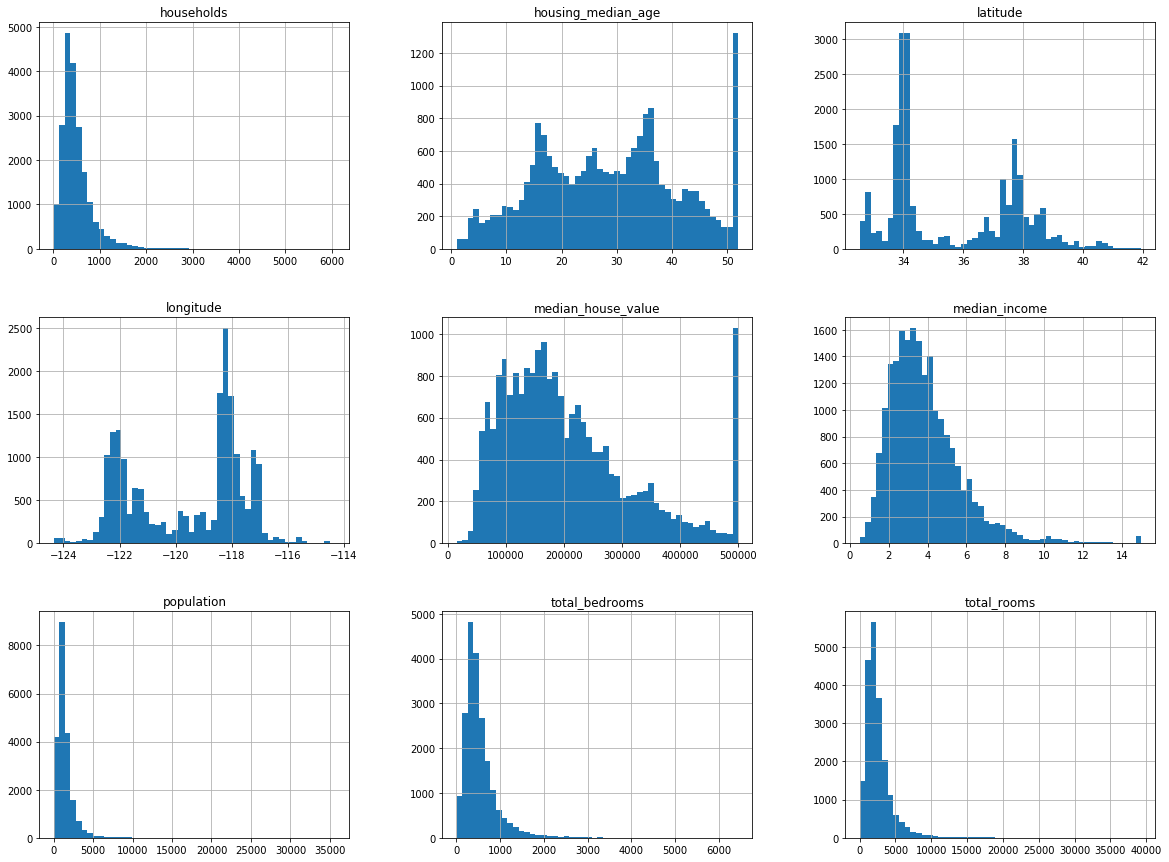

In [14]:
# 간단하게 데이터의 분포를 시각화합니다.
housing_data.hist(bins=50, figsize=(20, 15))
plt.show()

- 스케일을 살펴보면, `median_income` 특성이 달러로 표현되지 않았습니다.
- `housing_median_age`, `median_house_value`는 최대값과 최소값을 한정하였습니다.
    - Target value의 최대값이 한정된 경우는 심각한 문제가 발생할 수 있습니다. (\$500,000을 넘어가는 데이터에 대해서는 예측이 불가능)
        - Sol 1 : \$500,000이 넘어가는 데이터에 대해서 정확한 label을 얻습니다.
        - Sol 2 : 강제적으로 상한선이 \$500,000으로 된 데이터는 모두 삭제하고 훈련합니다.

### 2.1. Training set, test set 분리
데이터를 제대로 살펴보기 전에, 
 - <U>Train set과 test set을 분리</U>합니다. **데이터 스누핑**을 방지하기 위하여, test set을 train set과 명확하게 분리합니다. 
     - **데이터 스누핑** : 이미 모델에 노출된 test set을 이용하여 모델을 선택하여, 매우 낙관적인 추정이 되고 기대한 성능이 나오지 않는 것
 - Test set은 전체 data set에서 <U>중요한 특성의 카테고리를 잘 대표</U>해야 합니다. 즉 `median_income` 특성이 집 값 예측에 중요한 특성이라면, 해당 특성의 카테고리가 test set에 골고루 분포하도록 해야 합니다.

In [15]:
# Median income에서 골고루 test set을 뽑기 위하여, median income을 1~5의 카테고리로 나눕니다.
housing_data['income_cat'] = np.ceil(housing_data['median_income'] / 1.5)
housing_data['income_cat'].where(housing_data['income_cat'] < 5, 5.0, inplace=True)

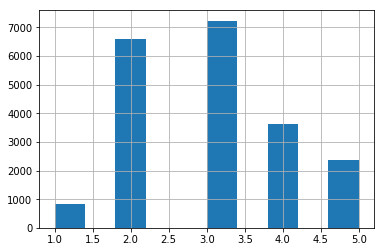

In [16]:
housing_data['income_cat'].hist()

Train set과 test set을 나눕니다. `StratifiedShuffleSplit`을 사용하면 특성의 카테고리 별 비율을 반영하여 data set을 나눌 수 있습니다.

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(housing_data, housing_data['income_cat']):
    strat_train_set = housing_data.loc[train_idx]
    strat_test_set = housing_data.loc[test_idx]

In [18]:
# Data set에서 income category의 비율
housing_data['income_cat'].value_counts() / len(housing_data)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [19]:
# Train set에서 income category의 비율
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [20]:
# Test set에서 income category의 비율
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

In [21]:
for _set in ([strat_train_set, strat_test_set]):
    _set.drop('income_cat', axis=1, inplace=True)

## 3. 데이터 탐색(EDA)
데이터 탐색과 시각화(**Exploratory data analysis**)입니다. 훈련 세트가 매우 크면 조작을 간단하고 빠르게 하기 위해 탐색을 위한 세트를 별도로 샘플링할 수 있습니다.

In [22]:
eda_train_set = strat_train_set.copy()

### 3.1 Plotting

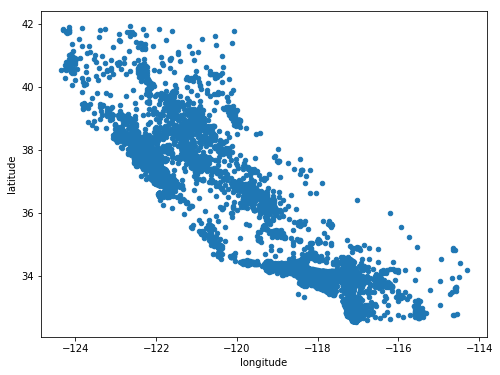

In [23]:
# 지리 정보(위도, 경도)가 있으므로 산점도 데이터 시각화를 합니다.
eda_train_set.plot(kind='scatter', x='longitude', y='latitude', figsize=(8, 6), fontsize=10, )

Scatter의 형태는 캘리포니아를 잘 나타내지만, 특별한 패턴을 찾기는 힘듭니다.

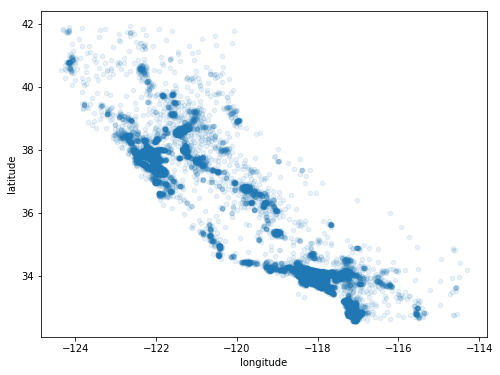

In [24]:
# 밀집된 지역을 나타냅니다.
eda_train_set.plot(kind='scatter', x='longitude', y='latitude', figsize=(8, 6), fontsize=10,  alpha=0.1) 

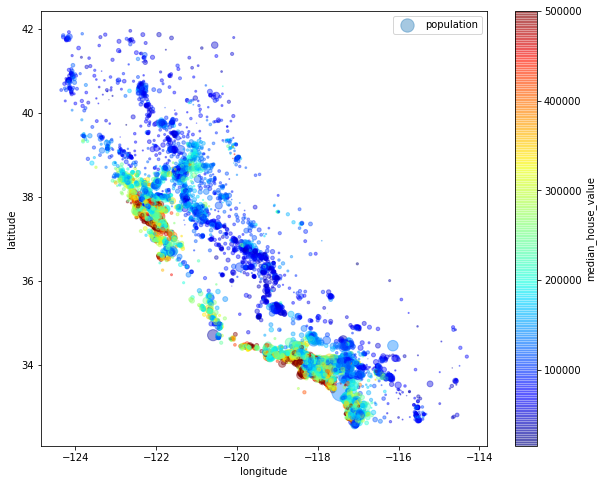

In [25]:
# 인구수는 scatter의 반지름 크기로 나타내고(s), 집 값은 scatter의 색깔을 나타낸다.
eda_train_set.plot(kind='scatter', x='longitude', y='latitude', figsize=(10, 8), fontsize=10, alpha=0.4,
                   s=eda_train_set['population']/100, label='population', c='median_house_value',
                   cmap=plt.get_cmap('jet'), colorbar=True, sharex=False)
plt.legend()

주택 가격은 위치(바다와 가까운 곳일 수록 높다)와 인구 밀도에 관련이 있다고 볼 수 있습니다.

### 3.2 상관관계
**상관관계(피어슨의 r)**를 조사합니다.

In [26]:
corr_matrix = eda_train_set.corr()

> 상관관계를 수치로 살펴보겠습니다.

In [27]:
# 중간 주택 가격과 다른 특성 사이의 상관관계를 살펴본다.
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

`median_income`이 올라갈때 `median_house_value`이 올라가는 경향이 있습니다. 위도(`latitude`)가 올라갈 때 즉 북쪽으로 갈 때 집 값은 감소하는 경향을 보이고 있습니다.

> 상관관계를 시각화 해보겠습니다.

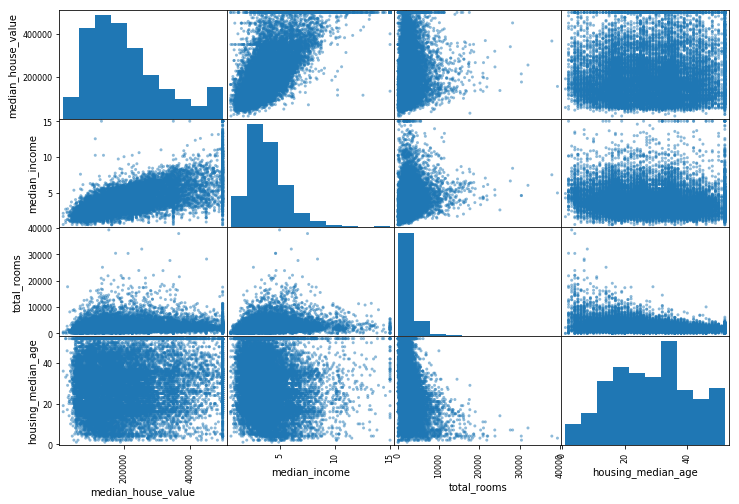

In [28]:
from pandas.plotting import scatter_matrix

attrs = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(eda_train_set[attrs], figsize=(12, 8))
plt.show()

예측에 가장 유용할 것 같은 `median_income`만 따로 확대해 봅니다.

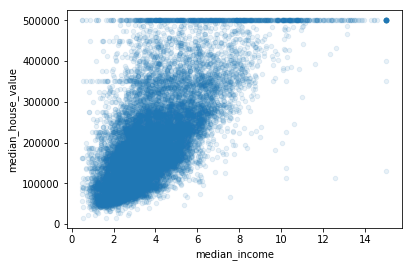

In [29]:
eda_train_set.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

> 상관 관계 분석을 통해 알 수 있는 것
 - 상관관계가 매우 강합니다. 위쪽으로 향하는 경향이 있으며, 포인트들이 널리 퍼져 있지 않습니다.
 - \\$500,000은 가격 제한 값이라서 수평선이 생성되는 것이 문제가 없지만, \\$450,000, \\$350,000, \\$280,000 에도 수평선이 존재합니다. 이러한 형태를 학습하지 않도록 해당 구역을 제거하는 것이 좋습니다.

#### 3.2.1 특성들을 조합하고, 조합한 특성의 상관관계 관찰

개별 특성에 대한 탐색 뿐 만이 아니라, **특성의 조합을 시도**해봅니다. 이것을 통하여, 특성 자체만으로는 의미가 없었지만 조합을 통하여 의미가 있도록 할 수 있습니다.
- 한 가구당 방 개수 (방 개수 / 가구 수)
- 방의 개수 대비 침대의 개수 (침대 수 / 방 개수)
- 한 가구당 인원 수 (인구 수 / 가구 수)

In [30]:
eda_train_set['room_per_household'] = eda_train_set['total_rooms'] / eda_train_set['households']
eda_train_set['bedrooms_per_room'] = eda_train_set['total_bedrooms'] / eda_train_set['total_rooms']
eda_train_set['population_per_household'] = eda_train_set['population'] / eda_train_set['households']

In [31]:
corr_matrix = eda_train_set.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
room_per_household          0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

`bedrooms_per_room`은 `total_bedrooms`이나 `total_rooms`보다 상관관계가 더 높습니다. (당연히, 더 큰 집이 비쌉니다.)

이 탐색 단계는 완벽하지 않습니다. <U>우선 처음에 얻은 통찰을 이용하여 프로토타입을 빠르게 생성하고 결과를 분석하여 더 많은 통찰을 얻은 후에, 이 탐색 단계로 돌아와서 결과를 바탕으로 데이터 탐색을 또 진행합니다.</U> 이 과정을 빠르게 반복하는 것이 필요합니다.

## 4. 데이터 준비 (가공 및 정제)

In [32]:
train_x = strat_train_set.drop('median_house_value', axis=1)
train_y = strat_train_set['median_house_value'].copy()
test_x = strat_test_set.drop('median_house_value', axis=1)
test_y = strat_test_set['median_house_value'].copy()

### 4.1 누락된 값에 대한 처리 방법
 - 해당 구역을 제거합니다. (해당하는 데이터만 제거)
 - 전체 특성을 삭제합니다. (해당하는 특성 자체를 사용하지 않음)
 - 어떤 값으로 채웁니다. (0, 평균, 중간값 등)

In [33]:
# 누락된 값을 확인합니다.
for col in train_x.columns:
    print(col, sum(train_x[col].isnull()))

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 158
population 0
households 0
median_income 0
ocean_proximity 0


`Imputer` 클래스는 누락된 값을 손쉽게 다루도록 해줍니다. 누락된 값을 중간값(median)으로 대체하겠습니다.

In [34]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='median')

In [35]:
# Numeric data를 가지고 와서 imputer에 fitting 합니다.
num_train = train_x._get_numeric_data()
imputer.fit(num_train)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [36]:
imputer.statistics_  # 중간값들

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [37]:
train_x_num = imputer.transform(num_train)
train_x_num = pd.DataFrame(train_x_num, columns=num_train.columns, index=train_x.index.values)

In [38]:
train_x_num.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214


Test set도 train set과 동일하게, imputer를 사용합니다. 단! <U>**train set에서의 스무딩값(여기서는 median)을 사용하여 test set을 스무딩한다**</U>는 것에 주의해야 합니다.

In [39]:
test_x_num = pd.DataFrame(imputer.transform(test_x._get_numeric_data()), 
                          columns=test_x._get_numeric_data().columns,
                          index=test_x.index.values)

In [40]:
test_x_num.head(2)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111


### 4.2 텍스트 feauture 또는 Categorical feature(범주형 특성) 다루기
- 텍스트는 feature는 sklearn 모델에서 학습할 수 없습니다. 정수 또는 실수의 형태로 바꾸어야 합니다. `LabelBinarizer`를 사용할 수 있습니다.
- Pandas의 `get_dummy`를 간단하게 사용할 수 있습니다.

In [41]:
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
ocean_proximity = encoder.fit_transform(strat_train_set['ocean_proximity']) 

In [42]:
# Sklearn의 labelbinarizer를 사용한 결과입니다.
ocean_proximity

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

In [43]:
# Pandas를 사용하겠습니다.
train_ocean_proximity_dummies = pd.get_dummies(strat_train_set['ocean_proximity'])
train_ocean_proximity_dummies.head()

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
17606,1,0,0,0,0
18632,1,0,0,0,0
14650,0,0,0,0,1
3230,0,1,0,0,0
3555,1,0,0,0,0


In [44]:
# Numerical data와 one hot vector data를 합칩니다.
train_x = pd.concat([train_x_num, train_ocean_proximity_dummies], axis=1)

In [45]:
train_x.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,1,0,0,0,0
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,1,0,0,0,0
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,0,0,0,0,1
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,0,1,0,0,0
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,1,0,0,0,0


In [46]:
# Test set도 동일하게 처리합니다.
test_ocean_proximity_dummies = pd.get_dummies(strat_test_set['ocean_proximity'])
test_ocean_proximity_dummies.head()

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
5241,1,0,0,0,0
10970,1,0,0,0,0
20351,1,0,0,0,0
6568,0,1,0,0,0
13285,0,1,0,0,0


In [47]:
test_x = pd.concat([test_x_num, test_ocean_proximity_dummies], axis=1)
test_x.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
5241,-118.39,34.12,29.0,6447.0,1012.0,2184.0,960.0,8.2816,1,0,0,0,0
10970,-117.86,33.77,39.0,4159.0,655.0,1669.0,651.0,4.6111,1,0,0,0,0
20351,-119.05,34.21,27.0,4357.0,926.0,2110.0,876.0,3.0119,1,0,0,0,0
6568,-118.15,34.20,52.0,1786.0,306.0,1018.0,322.0,4.1518,0,1,0,0,0
13285,-117.68,34.07,32.0,1775.0,314.0,1067.0,302.0,4.0375,0,1,0,0,0


In [48]:
# Feature의 리스트를 따로 저장합니다.
feature_list = train_x.columns.values

### 4.3 Feature scaling
 - 머신러닝 알고리즘은 입력 숫자 특성들의 스케일이 많이 다르면 잘 작동하지 않습니다. 최적값으로 수렴하는데에 특정 feature의 영향이 너무 클 수 있습니다.
 - **min-max scaling**
  - 데이터에서 최소값을 뺀 후 최대값과 최솟값의 차이로 나눕니다. `MinMaxSclaer`
 - **표준화(standardization)**
  - 데이터에서 평균을 뺀 후 표준편차를 나누어 결과 분포의 분산이 1이 되도록 합니다. `StandardScaler`

In [49]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_x)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [50]:
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)

위의 과정을 자동화하기 위하여 `Pipeline`을 사용할 수 있습니다. 이것은 나중에 배우도록 하겠습니다.

## 5. 모델 선택과 훈련

### 5.1 Linear Regression

In [51]:
from sklearn.linear_model import LinearRegression

In [52]:
lin_reg = LinearRegression()
lin_reg.fit(train_x, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [53]:
x_samples = train_x[:5]
y_samples = train_y[:5]

In [54]:
print('Predictions: ', lin_reg.predict(x_samples))

Predictions:  [211574.39523833 321345.10513719 210947.519838    61921.01197838
 192362.32961119]


In [55]:
print('Labels: ', list(y_samples))

Labels:  [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


회귀모형의 성능 평가 지표중의 하나인 **RMSE**를 사용하여 모델의 성능을 살펴보겠습니다.

In [56]:
from sklearn.metrics import mean_squared_error

predictions = lin_reg.predict(train_x)
lin_mse = mean_squared_error(train_y, predictions)
lin_rmse = np.sqrt(lin_mse)

print(lin_rmse)

69050.98178244587


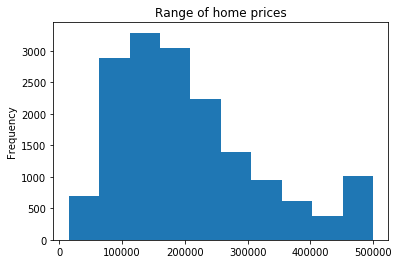

In [57]:
train_y.plot(kind='hist', title='Range of home prices')

집 값의 분포와 비교해보면 RMSE는 좋은 값이 아닙니다.

#### Linear regression의 cross validation scores

> **교차 검증(Cross validation)**
- 여러 모델의 성능을 비교하여 모델을 평가하거나, 모델의 파라미터를 결정하기 위해 교차 검증을 사용합니다.
- 학습 셋을 더 작은 학습 셋과 검증 셋으로 나누어, 작은 학습 셋에서 모델을 학습하고 검증 셋에서 모델을 검증합니다.

In [58]:
from sklearn.model_selection import cross_val_score

In [59]:
lin_scores = cross_val_score(lin_reg, train_x, train_y, scoring='neg_mean_squared_error', cv=10)
lin_rmse_cv_scores = np.sqrt(-lin_scores)

In [60]:
# Cross validation score를 확인하기 위한 함수를 구현합니다.
def display_scores(scores):
    print('Scores', scores)
    print('Mean', scores.mean())
    print('Std deviation', scores.std())

In [61]:
display_scores(lin_rmse_cv_scores)

Scores [67455.95696656 67337.87238873 68360.13975218 74624.10000638
 68312.13873619 71627.85172742 65360.14556385 68575.33265235
 72499.22378911 68100.16327885]
Mean 69225.29248616142
Std deviation 2655.955681175142


성능을 비교하기 위하여 결정트리 모델의 cross validation scores를 사용합니다.

### 5.2 DecisionTree
#### DecisionTree의 cross validation score

In [62]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_scores = cross_val_score(tree_reg, train_x, train_y, scoring='neg_mean_squared_error', cv=10)
tree_rmse_cv_scores = np.sqrt(-tree_scores)

display_scores(tree_rmse_cv_scores)

Scores [66961.02256454 66255.1504283  73426.88061527 69562.77113486
 67708.05300134 74900.30528212 67844.55197365 69785.5217129
 71048.00822403 69498.02502789]
Mean 69699.02899648935
Std deviation 2638.112899271263


### 5.3 RandomForestClassifier
5.3.1 RandomForestClassifier의 cross validation score

In [63]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()
rf_scores = cross_val_score(rf_reg, train_x, train_y, scoring='neg_mean_squared_error', cv=10)
rf_rmse_cv_scores = np.sqrt(-rf_scores)

# 검증 셋에 대한 RMSE 값입니다.
display_scores(rf_rmse_cv_scores)

Scores [51252.51004355 48334.68428352 50974.27617392 52730.18551089
 51373.61973435 55006.48471961 50373.90915805 53863.90016603
 54462.86212593 51380.80381986]
Mean 51975.3235735731
Std deviation 1938.3282267570175


랜덤 포레스트 모델이 선형 회귀 모델과 비교했을때 모델 성능 지표가 더 높게 나왔습니다. 

In [64]:
rf_reg.fit(train_x, train_y)
pred = rf_reg.predict(train_x)

# 학습 셋에 대한 RMSE 값입니다.
np.sqrt(mean_squared_error(train_y, pred))

22067.10837477592

하지만 학습 셋에 대한 RMSE의 값이 검증 셋에 대한 RMSE 보다 많이 낮습니다. 그 이유는 Random forest 모델이 **과대적합(overfitting)** 되었기 때문입니다. 과대적합을 피하기 위해서는 다음과 같은 방법이 있습니다.
 - 모델을 간단히 한다.
 - 제한을 한다 즉 규제(Regularization)를 한다.
 - 더 많은 훈련 데이터를 모은다.
 
모델을 선택하기 전에, 여러 종류의 머신러닝 알고리즘으로 하이퍼파라미터 조정에 너무 많은 시간을 들이지 않으면서 <U>다양한 모델들을 시도</U>해야 합니다. 가능성 있는 2~5개의 모델을 선정하는것이 목적입니다.

## 6. 모델 세부 튜닝
가능성 있는 모델들을 추렸다고 가정합시다. 이 모델들을 세부 튜닝해야 합니다. 튜닝 방법에는 대표적으로 아래와 같은 방법들이 있습니다.
 - 그리드 탐색
 - 랜덤 선택
 - 앙상블 방법

### 6.1. 그리드 탐색
 - sklearn의 `GridSearchCV`

In [65]:
from sklearn.model_selection import GridSearchCV

# 탐색할 parameter set : 전체 훈련 횟수는 18 * 5 = 90 입니다.
params = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}
]

# 모델
forest_reg = RandomForestRegressor()

# 그리드 탐색
grid_search = GridSearchCV(forest_reg, params, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(train_x, train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [66]:
# 가장 좋은 파라미터
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [67]:
# 가장 좋은 Tree model
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [68]:
# 각 파라미터에 대한 평가 점수
cv_results = grid_search.cv_results_
for mean_score, params in zip(cv_results['mean_test_score'], cv_results['params']):
    print(np.sqrt(-mean_score), params)

63803.67887330699 {'max_features': 2, 'n_estimators': 3}
55713.43427866987 {'max_features': 2, 'n_estimators': 10}
53011.04488231292 {'max_features': 2, 'n_estimators': 30}
60108.9004994121 {'max_features': 4, 'n_estimators': 3}
53089.71965526012 {'max_features': 4, 'n_estimators': 10}
50832.019879068874 {'max_features': 4, 'n_estimators': 30}
59516.45895867425 {'max_features': 6, 'n_estimators': 3}
52821.24059936285 {'max_features': 6, 'n_estimators': 10}
50315.27572619848 {'max_features': 6, 'n_estimators': 30}
57867.40549649622 {'max_features': 8, 'n_estimators': 3}
52038.534197657995 {'max_features': 8, 'n_estimators': 10}
50172.83789488855 {'max_features': 8, 'n_estimators': 30}
61630.7678008934 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54504.540184760786 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59968.169434973825 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53284.88873557027 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

앞의 예에서 봤던 RMSE는 평균 52247.025765264174 이었지만 파라미터 튜닝 결과 얻은 RMSE는 평균 50057.411415517876 입니다. 8, 30은 각 파라미터의 최대값이었기 때문에 모델의 성능을 더 향상시킬 수 있습니다.

### 6.2 랜덤 탐색
sklearn의 `RandomizedSearchCV`를 사용합니다. 후보 중에서 파라미터를 랜덤하게 선택하여 모델을 생성합니다.

## 7. 모델 분석 및 최종 모델 평가 (솔루션 제시)

In [69]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([1.10160887e-01, 1.04176385e-01, 5.17140108e-02, 2.95643283e-02,
       2.67067957e-02, 3.65353927e-02, 2.43286053e-02, 4.39932905e-01,
       1.08801675e-02, 1.54951367e-01, 7.67376248e-06, 3.66522329e-03,
       7.37625852e-03])

In [70]:
sorted(zip(feature_importances, feature_list), reverse=True)

[(0.43993290482024966, 'median_income'),
 (0.15495136690841121, 'INLAND'),
 (0.11016088714226073, 'longitude'),
 (0.10417638534804556, 'latitude'),
 (0.05171401076346914, 'housing_median_age'),
 (0.03653539266469021, 'population'),
 (0.029564328309021712, 'total_rooms'),
 (0.026706795720807485, 'total_bedrooms'),
 (0.02432860529702204, 'households'),
 (0.01088016745003218, '<1H OCEAN'),
 (0.00737625851927545, 'NEAR OCEAN'),
 (0.0036652232942390533, 'NEAR BAY'),
 (7.673762475550955e-06, 'ISLAND')]

In [71]:
final_model = grid_search.best_estimator_

final_pred = final_model.predict(test_x)
final_rmse = np.sqrt(mean_squared_error(test_y, final_pred))

final_rmse

47243.48796130682

테스트 셋을 평가할 때, 하이퍼파라미터 튜닝을 많이 했으면 교차 검증을 사용해 측정한 것보다 조금 성능이 낮은 경우가 많습니다. 검증 데이터에서 좋은 성능을 내도록 세밀하게 튜닝되었기 때문에(검증 데이터에 과대적합 될 가능성이 높습니다.) 새로운 데이터셋에서는 잘 작동하지 않을 수 있다는 것을 명심해야 합니다.